# Аналитика маркетинговой кампании Яндекс.Афиши

**Описание проекта**

Отделу маркетинговой аналитики Яндекс.Афиши требуется снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет. Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
+ лог сервера с данными о посещениях сайта Яндекс.Афиши,
+ выгрузка всех заказов за этот период,
+ статистика рекламных расходов.

**Цель исследования** выяснить:
+ как клиенты пользуются сервисом,
+ когда делают первые покупки на сайте,
+ сколько денег приносит компании каждый клиент,
+ когда расходы на привлечение клиента окупаются.

Выручка измеряется в условных единицах — у.е.

**Описание данных**

Файл **visits_log.csv** хранит лог сервера с информацией о посещениях сайта, **orders_log.csv** — информацию о заказах, а **costs.csv** — информацию о расходах на маркетинг.

**Структура visits_log.csv**
+ Uid — уникальный идентификатор пользователя,
+ Device — категория устройства пользователя,
+ Start Ts — дата и время начала сессии,
+ End Ts — дата и время окончания сессии,
+ Source Id — идентификатор источника перехода на сайт.

**Структура orders_log.csv**
+ Uid — уникальный идентификатор пользователя,
+ Buy Ts — дата и время заказа,
+ Revenue — сумма заказа.

**Структура costs.csv**
+ source_id — идентификатор рекламного источника,
+ dt — дата проведения рекламной кампании,
+ costs — расходы на эту кампанию.

## Изучение и предобработка данных
Изучим данные, для этого прочитаем файлы и выведем общую информацию о нем. Также импортируем все библиотеки, которые мы будем использовать.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cbook
import seaborn as sns
from scipy import stats as st
import warnings
import random
import plotly.graph_objects as go
import plotly.express as px

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

print ('\033[4m\033[1m' + 'Визиты' + '\033[0m')
print(visits.info())
print ('\033[4m\033[1m' + 'Заказы' + '\033[0m')
print(orders.info())
print ('\033[4m\033[1m' + 'Расходы' + '\033[0m')
print(costs.info())


Визиты
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None
Заказы
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None
Расходы
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None


Приведем названия столбцов к одному регистру, заменим пробелы на нижнее подчеркивание. Для удобства изменим порядок столбцов. Изменим тип данных на дату, там, где это необходимо.

In [3]:
visits.columns = visits.columns.str.replace(' ','_')
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.replace(' ','_')
orders.columns = orders.columns.str.lower()
costs.columns = costs.columns.str.replace(' ','_')
costs.columns = costs.columns.str.lower()

visits = visits[['uid','device','start_ts','end_ts','source_id']]
orders = orders[['uid', 'buy_ts', 'revenue']]

visits[['start_ts','end_ts']] = visits[['start_ts','end_ts']].apply(pd.to_datetime)
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

На всякий случай проверим данные на дубликаты:

In [4]:
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


Проверим временные рамки сбора данных.

In [5]:
date_dict ={'Визиты': visits['start_ts'], 'Заказы':orders['buy_ts'], 'Маркетинговые расходы':costs['dt']}

for key, val in date_dict.items():
    print('Данные в таблице {} собирались с {} по {}'.
      format(key, val.min(), val.max()))


Данные в таблице Визиты собирались с 2017-06-01 00:01:00 по 2018-05-31 23:59:00
Данные в таблице Заказы собирались с 2017-06-01 00:10:00 по 2018-06-01 00:02:00
Данные в таблице Маркетинговые расходы собирались с 2017-06-01 00:00:00 по 2018-05-31 00:00:00


### Вывод
В рамках изучения и предобработки данных мы изучили характер данных, привели названия столбцов к удобному нам виду, изменили их порядок и поменяли тип данных там, где это было необходимо. Данные не содержат пропусков и дубликатов и собирались с 1 июня 2017 по 1 июня 2018.

## Расчет метрик

### Продуктовые метрики
#### Рассчитаем DAU, WAU и MAU. Вычислим средние значения этих метрик за весь период. Отобразим изменения метрик во времени на графиках.
Чтобы посчитать недельное и месячное использование, выделим в отдельные столбцы год, месяц и неделю, а также полную дату.

In [6]:
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week'] = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date
visits.head()

,uid,device,start_ts,end_ts,source_id,session_year,session_month,session_week,session_date
0,16879256277535980062,touch,2017-12-20 17:20:00,2017-12-20 17:38:00,4,2017,12,51,2017-12-20
1,104060357244891740,desktop,2018-02-19 16:53:00,2018-02-19 17:21:00,2,2018,2,8,2018-02-19
2,7459035603376831527,touch,2017-07-01 01:54:00,2017-07-01 01:54:00,5,2017,7,26,2017-07-01
3,16174680259334210214,desktop,2018-05-20 10:59:00,2018-05-20 11:23:00,9,2018,5,20,2018-05-20
4,9969694820036681168,desktop,2017-12-27 14:06:00,2017-12-27 14:06:00,3,2017,12,52,2017-12-27


Посчитаем метрики. Сгруппируем данные по соответствующим периодам и найдём среднее значение уникальных пользователей.

In [7]:
dau = visits.groupby('session_date').agg({'uid':'nunique'})
wau = visits.groupby(['session_year', 'session_week']).agg({'uid':'nunique'})
mau = visits.groupby(['session_year', 'session_month']).agg({'uid':'nunique'})
print('DAU {}, WAU {}, MAU {}'.format(int(dau.mean()), int(wau.mean()), int(mau.mean())))

DAU 907, WAU 5716, MAU 23228


Отобразим изменения метрик во времени на графиках.

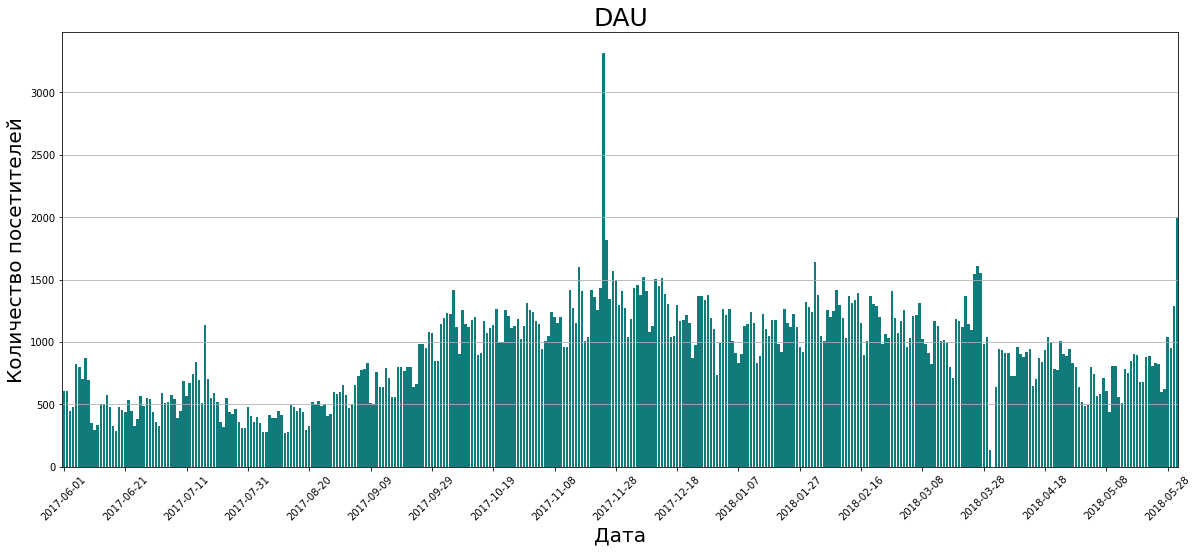

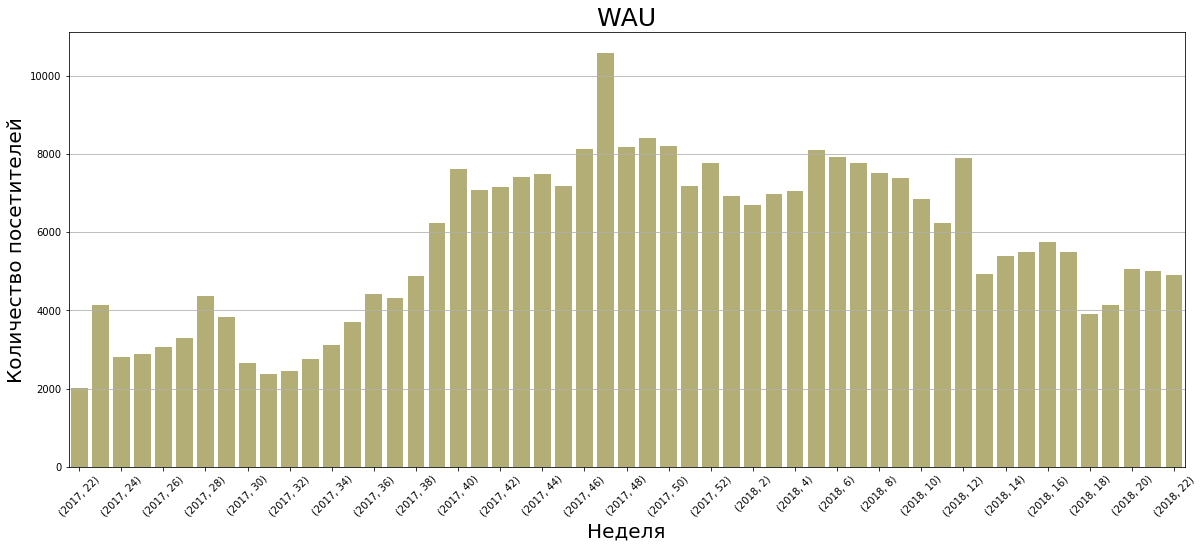

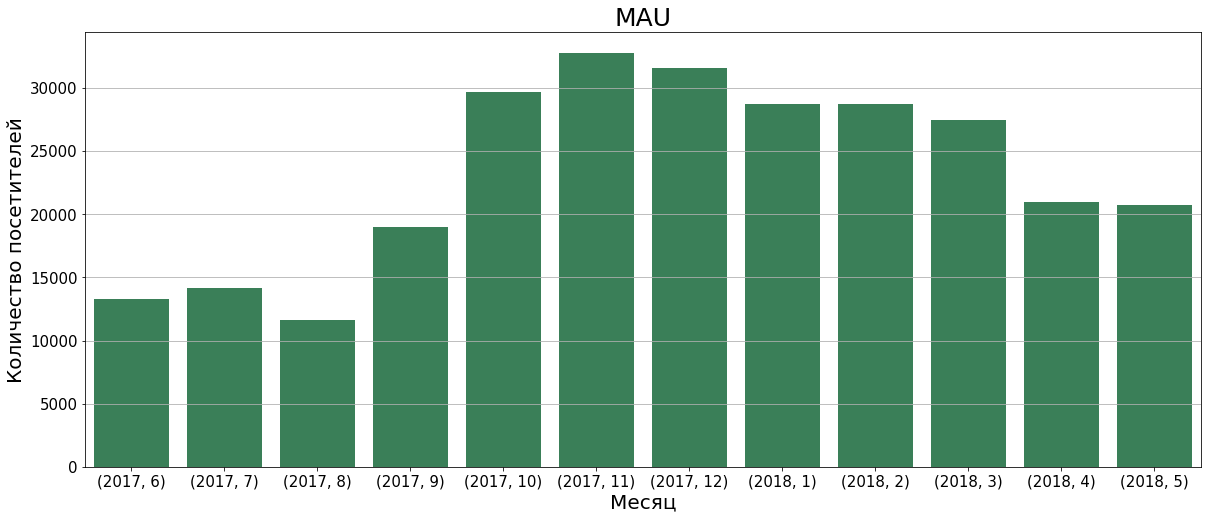

In [8]:
plt.figure(figsize=[20,8])
ax=sns.barplot(data=dau, x=dau.index, y='uid', color='darkcyan')
ax.axes.set_title('DAU',fontsize=25)
ax.set_xlabel('Дата',fontsize=20)
ax.set_ylabel('Количество посетителей',fontsize=20)
new_ticks = [i.get_text() for i in ax.get_xticklabels()] # Читаем тикеры
plt.xticks(range(0, len(new_ticks), 20), new_ticks[::20], rotation=45) # "Прореживаем" тикеры
ax.yaxis.grid(True)
plt.show()

plt.figure(figsize=[20,8])
ax=sns.barplot(data=wau, x=wau.index, y='uid', color='darkkhaki')
ax.axes.set_title('WAU',fontsize=25)
ax.set_xlabel('Неделя',fontsize=20)
ax.set_ylabel('Количество посетителей',fontsize=20)
new_ticks = [i.get_text() for i in ax.get_xticklabels()] # Читаем тикеры
plt.xticks(range(0, len(new_ticks), 2), new_ticks[::2], rotation=45) # "Прореживаем" тикеры
ax.yaxis.grid(True)
plt.show()

plt.figure(figsize=[20,8])
ax=sns.barplot(data=mau, x=mau.index, y='uid', color='seagreen')
ax.axes.set_title('MAU',fontsize=25)
ax.set_xlabel('Месяц',fontsize=20)
ax.set_ylabel('Количество посетителей',fontsize=20)
ax.tick_params(labelsize=15)
ax.yaxis.grid(True)
plt.show()

Похоже, в конце ноября был день, когда на ресурс зашло аномально большое число новых пользователей. В целом больше всего новых пользователей пришло в ноябре и декабре. Ярко выражена сезонность - в летние месяцы новых пользователей явно меньше.

#### Определим, сколько раз за день пользователи в среднем заходят на сайт. Построим график, отражающий изменения метрики во времени

In [9]:
visits_per_day = visits.groupby('session_date').agg({'uid':['count','nunique']})
visits_per_day.columns = ['n_sessions', 'n_users']
visits_per_day['visits_per_day'] = visits_per_day['n_sessions'] / visits_per_day['n_users']
print('В среднем пользователи заходят на сайт {:.2f} раз за день.'.format(visits_per_day['visits_per_day'].mean()))
visits_per_day = visits_per_day.reset_index()

В среднем пользователи заходят на сайт 1.08 раз за день.


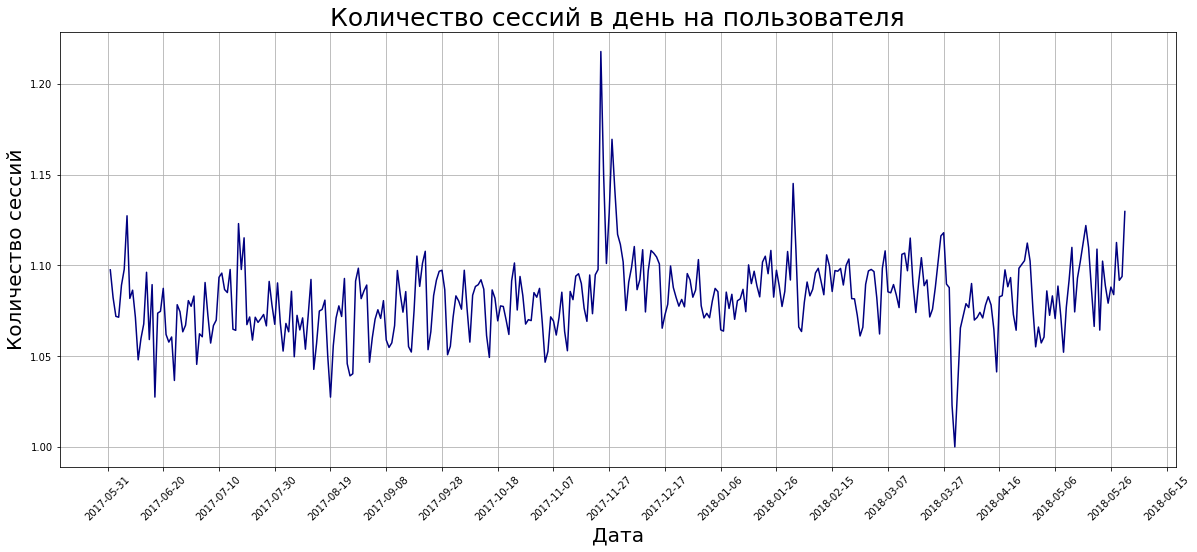

In [10]:
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=[20,8])
ax=sns.lineplot(data=visits_per_day, x='session_date', y='visits_per_day', color='navy')
ax.axes.set_title('Количество сессий в день на пользователя',fontsize=25)
ax.set_xlabel('Дата',fontsize=20)
ax.set_ylabel('Количество сессий',fontsize=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(20)) # Ставим более частые "тикеры"
plt.xticks(rotation=45) 
ax.yaxis.grid(True)
ax.xaxis.grid(True)
plt.show()

#### Выясним, сколько времени пользователи проводят на сайте. Узнаем продолжительность типичной пользовательской сессии за весь период. 
Чтобы выбрать подходящую среднюю меру, построим график распределения.

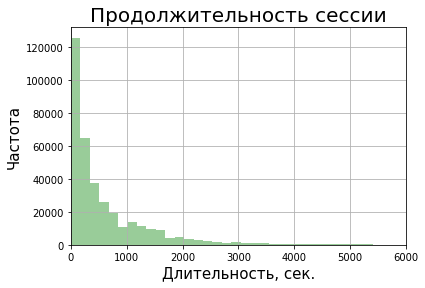

In [11]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
sns.distplot(visits['session_duration_sec'], kde=False, color='green', bins=500)
plt.title('Продолжительность сессии', fontsize=20)
plt.xlabel('Длительность, сек.', fontsize=15)
plt.ylabel('Частота', fontsize=15)
plt.xlim(0,6000)
plt.grid(True)
plt.show()

Продолжительности распределены не нормально, используем моду для оценки средней продолжительности.

In [12]:
print('Средняя продолжительность сессии составляет {} секунд.'.format(visits['session_duration_sec'].mode()[0]))

Средняя продолжительность сессии составляет 60 секунд.


Как видим, большинству пользователей хватает минуты на ресурсе. Успевают ли они за эту минуту узнать нужную информацию? Или сталкиваются с трудностями и больше никогда не заходят на сайт? Попробуем узнать. <a id='fast_users'></a>

In [13]:
# Создаем индикатор, если "быстрый" пользователь в дальнейшем что-то купил - ставим 1
visits.loc[(visits['session_duration_sec'] <= 60) & (visits['uid'].isin(orders['uid'])), 'fast_user_buy'] = 1
visits['fast_user_buy'] = visits['fast_user_buy'].fillna(0) # Заполняем нулями все остальное
print('Из пользователей, которые провели на сайте меньше минуты, в дальнейшем совершили покупку {:.2%}.'.format(
    visits.loc[(visits['session_duration_sec'] <= 60)]['fast_user_buy'].mean()))


Из пользователей, которые провели на сайте меньше минуты, в дальнейшем совершили покупку 17.07%.


Возможно действительно имеется проблема. Проверим, есть ли зависимость от девайса либо источника трафика? Сравнивать будем теми, кто провел на сайте больше минуты и успешно осуществил покупку.

In [14]:
fast_users_not_buy = visits.loc[(visits['session_duration_sec'] <= 60) & visits['fast_user_buy'] == 0]
slow_buyers = visits.loc[(visits['session_duration_sec'] > 60) & (visits['uid'].isin(orders['uid']))]
# Считаем доли девайсов и источников в обоих группах
print ('\033[4m\033[1m' + 'Не купили' + '\033[0m')                                                                  
display(fast_users_not_buy['device'].value_counts()/fast_users_not_buy['device'].value_counts().sum())
display(fast_users_not_buy['source_id'].value_counts()/fast_users_not_buy['source_id'].value_counts().sum())
print ('\033[4m\033[1m' + 'Купили' + '\033[0m')                                                                  
display(slow_buyers['device'].value_counts()/slow_buyers['device'].value_counts().sum())
display(slow_buyers['source_id'].value_counts()/slow_buyers['source_id'].value_counts().sum())

Не купили


desktop    0.730226
touch      0.269774
Name: device, dtype: float64

4     0.285479
3     0.240976
5     0.187177
2     0.129332
1     0.093187
9     0.035726
10    0.028001
7     0.000105
6     0.000017
Name: source_id, dtype: float64

Купили


desktop    0.814463
touch      0.185537
Name: device, dtype: float64

4     0.224740
2     0.194174
3     0.186500
1     0.171735
5     0.149952
9     0.046415
10    0.026472
7     0.000012
Name: source_id, dtype: float64

Разница небольшая, но она есть. Например, среди некупивших больше доля мобильных пользователей, чем среди купивших. По источникам тоже есть различия. Имеет смысл сообщить об обнаруженной закономерности разработчикам.

#### Рассчитаем Retention Rate, применяя когортный анализ. 
Покажем изменения метрики во времени на графике. Найдем средний Retention Rate на второй месяц «жизни» когорт. Для этого определим для каждого пользователя дату первой сессии.

In [15]:
first_activity_date = visits.groupby('uid')['session_date'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.join(first_activity_date, on='uid')

Определим первый месяц активности пользователя и месяц сессии в формате 'datetime'. Посчитаем lifetime и число активных пользователей на каждый "месяц жизни".

In [16]:
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')
visits['activity_month'] = visits['start_ts'].astype('datetime64[M]')
visits['cohort_lifetime'] = visits['activity_month'] - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')
cohorts = visits.groupby(['first_activity_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

Найдём исходное количество пользователей в когорте. Добавим в таблицу с когортами соответствующий столбец.

In [17]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 
cohorts = cohorts.merge(initial_users_count, on='first_activity_month') 

Рассчитаем **Retention Rate**, для этого разделим количество активных пользователей в каждую из недель на исходное число пользователей в когорте. Построим сводную таблицу и создадим тепловую карту. Найдем средний Retention Rate на второй месяц «жизни» когорт.

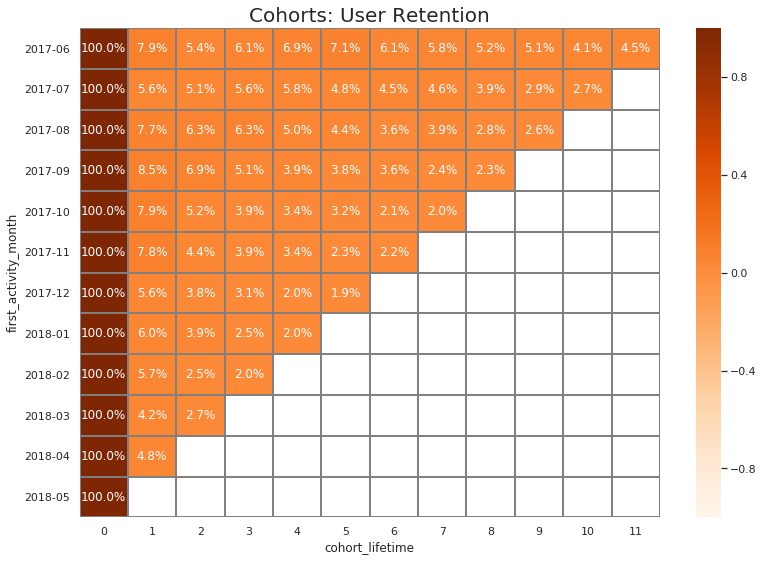



Cредний Retention Rate на второй месяц «жизни» когорт составляет 4.63%


In [18]:
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']
cohorts['first_activity_month'] = cohorts['first_activity_month'].dt.strftime('%Y-%m')

retention_pivot = cohorts.pivot_table(
    index='first_activity_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
) 
     
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention', fontsize=20)
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap='Oranges', vmin=-1, vmax=1, center= 0)
plt.show()

print()
print()
print('Cредний Retention Rate на второй месяц «жизни» когорт составляет {:.2%}'.format(retention_pivot[2].dropna().mean()))

Как видим, достаточно маленькая доля пользователей продолжает пользоваться сервисом последующие месяцы. В целом доля таких пользователей колеблется от 10% до 2%

### Метрики электронной коммерции
#### Выясним, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки.

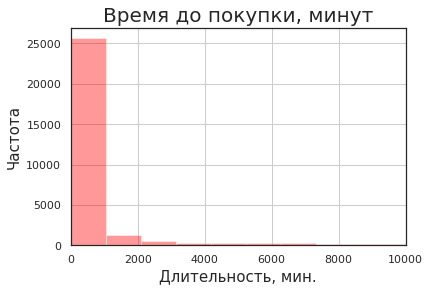

В среднем, с момента первого посещения сайта до совершения покупки проходит 17 дней.
При этом самое частое время, которое требуется пользователю для покупки - 60 секунд.


In [19]:
visits_grouped = visits.groupby('uid')['start_ts'].min().reset_index()
orders_grouped = orders.groupby('uid')['buy_ts'].min().reset_index()
visits_grouped = visits_grouped.merge(orders_grouped, on='uid')
visits_grouped['time_to_buy'] = visits_grouped['buy_ts'] - visits_grouped['start_ts']

sns.distplot((visits_grouped['time_to_buy'] / np.timedelta64(1, 'm')), kde=False, color='red', bins=500)
plt.title('Время до покупки, минут', fontsize=20)
plt.xlabel('Длительность, мин.', fontsize=15)
plt.ylabel('Частота', fontsize=15)
plt.xlim(0,10000)
plt.grid(True)
plt.show()

print('В среднем, с момента первого посещения сайта до совершения покупки проходит {} дней.'
      .format(round(visits_grouped['time_to_buy'].mean() / np.timedelta64(1, 'D'))))
print('При этом самое частое время, которое требуется пользователю для покупки - {} секунд.'
      .format(round(visits_grouped['time_to_buy'].mode()[0] / np.timedelta64(1, 's'))))


Все же достаточно большое количество пользователей успевают совершить покупку за 60 секунд. Возможно, наши [опасения](#fast_users) безосновательны. Такое время может говорить о целеноправленном решении совершить покупку, сформировавшемся до посещения сайта. Посмотрим, откуда чаще всего приходят такие клиенты.

In [20]:
fast_buyers = visits.loc[(visits['session_duration_sec'] <= 60) & (visits['uid'].isin(orders['uid']))]
display(fast_buyers['source_id'].value_counts()/fast_buyers['source_id'].value_counts().sum())

4     0.232754
2     0.204076
3     0.175856
5     0.163248
1     0.134309
9     0.064280
10    0.025477
Name: source_id, dtype: float64

Кардинальных различий с предыдущими результатами нет

#### Рассчитаем среднее количество покупок на одного покупателя за 6 месяцев.

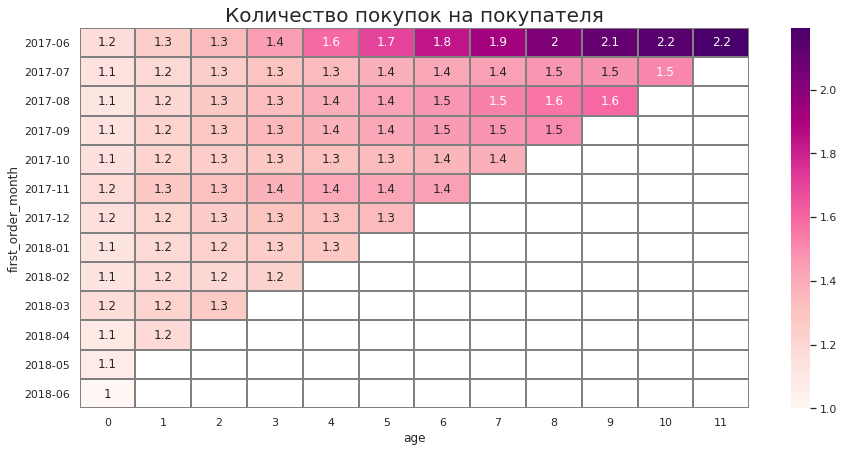

In [21]:
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')
avg_purch = orders[['uid','buy_month']] # Выберем нужные столбцы в отдельную таблицу, чтобы не путаться

first_order_avg = avg_purch.groupby('uid').agg({'buy_month':'min'}).reset_index() # Месяц первой покупки
first_order_avg.columns = ['uid','first_order_month']
avg_purch = avg_purch.merge(first_order_avg, on='uid')
    # Найдем новых покупателей в каждом месяце
cohort_sizes_avg = first_order_avg.groupby('first_order_month').agg({'uid':'nunique'}).reset_index() 
cohort_sizes_avg.columns = ['first_order_month','n_buyers'] 
    # Построим когорты, найдем количество заказов в каждом месяце
cohorts_avg = avg_purch.groupby(['first_order_month', 'buy_month']).agg({'uid': 'count'}).reset_index() 
    # Объединим таблицы, посчитаем возраст когорт и количество заказов на человека
report_avg = cohorts_avg.merge(cohort_sizes_avg, on='first_order_month')
report_avg['age'] = (report_avg['buy_month'] - report_avg['first_order_month']) / np.timedelta64(1, 'M')
report_avg['age'] = report_avg['age'].round().astype('int')
report_avg['purch_per_user'] = report_avg['uid'] / report_avg['n_buyers']
    # Построим сводную таблицу по когортам, с заказами на человека в качестве значений
report_avg_pivot = report_avg.pivot_table(index= 'first_order_month', columns= 'age', values= 'purch_per_user', aggfunc='mean')
    # Количество покупателей в когорте не меняется, а количество покупок растет с каждым месяцем, количество
    # заказов на человека должно расти, используем кумулятивную сумму
report_avg_pivot = report_avg_pivot.cumsum(axis=1)
    # Выводим таблицу
sns.set(style='white')
plt.figure(figsize=(15, 7))
ax=sns.heatmap(report_avg_pivot, annot=True, linewidths=1, linecolor='gray', cmap='RdPu')
plt.title('Количество покупок на покупателя', fontsize=20)
ticklabels = [report_avg_pivot.index[int(tick)].strftime('%Y-%m') for tick in ax.get_yticks()] # Меняем формат тикеров на оси Y
ax.set_yticklabels(ticklabels)
plt.show()

Для определения среднего количества покупок на одного покупателя за 6 месяцев, возьмем когорты с временем жизни не меньше 6 месяцев и посчитаем среднее значение на шестом месяце жизни

In [22]:
avg_purch6=report_avg_pivot[:6][6].mean()
print('Среднее количество покупок на одного покупателя за 6 месяцев составляет {:.2f}.'.format(avg_purch6))

Среднее количество покупок на одного покупателя за 6 месяцев составляет 1.50.


А теперь для интереса сравним количество посетителей и количество покупателей.

In [23]:
print('Покупателями становятся {:.2%} от общего числа посетителей'.format(orders['uid'].nunique()/visits['uid'].nunique()))

Покупателями становятся 16.01% от общего числа посетителей


#### Рассчитаем средний чек, применяя группировку по времени совершения покупки.  Построим график, отражающий изменения метрики во времени.

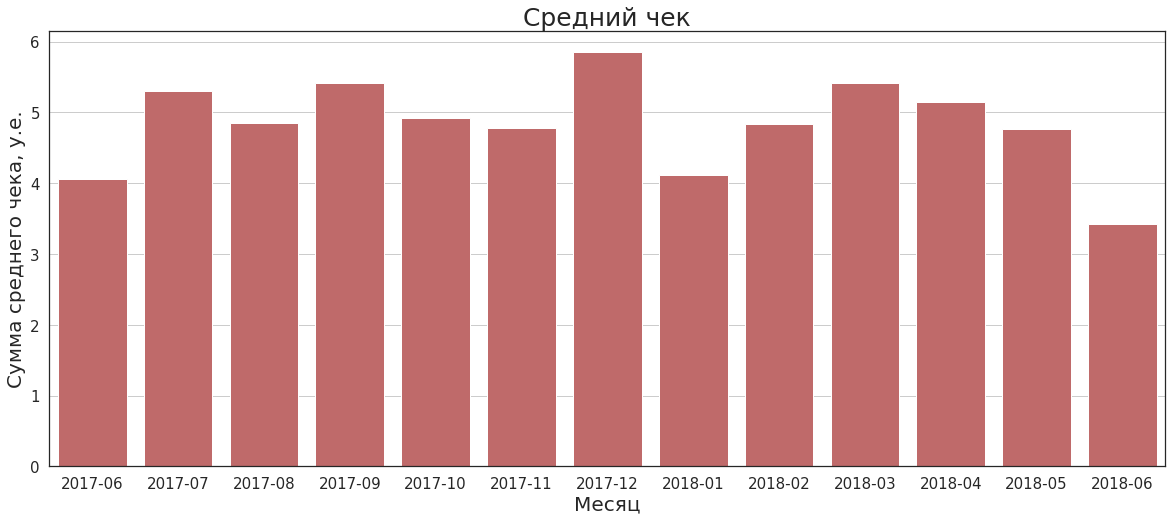

Средний чек составляет 4.84 условные единицы.


In [24]:
avg_rev = orders.groupby(['buy_month']).agg({'uid':'count', 'revenue':'sum'}).reset_index()
avg_rev['avg_rev'] = avg_rev['revenue'] / avg_rev['uid']

plt.figure(figsize=[20,8])
ax=sns.barplot(data=avg_rev, x=avg_rev['buy_month'].dt.strftime('%Y-%m'), y='avg_rev', color='indianred')
ax.axes.set_title('Средний чек',fontsize=25)
ax.set_xlabel('Месяц',fontsize=20)
ax.set_ylabel('Сумма среднего чека, у.е.',fontsize=20)
ax.tick_params(labelsize=15)
ax.yaxis.grid(True)
plt.show()

print('Средний чек составляет {:.2f} условные единицы.'.format(avg_rev['avg_rev'].mean()))

Сравним со значением, полученным другим методом. Заодно оценим минимальные и максимальные значения.

In [25]:
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

#### Выясним, как меняется LTV на покупателя по когортам. 
Расчитаем средний LTV по когортам за 6 месяцев; в расчёт включим когорты, «прожившие» не менее 6 месяцев. Маржинальность сервиса — 100%. Отразим изменения метрики во времени на графике.

Добавим столбец с месяцем первого заказа и найдем количество новых покупателей в каждом месяце.

In [26]:
first_order = orders.groupby('uid').agg({'buy_month':'min'}).reset_index()
first_order.columns = ['uid','first_order_month']

cohort_sizes = first_order.groupby('first_order_month').agg({'uid':'nunique'}).reset_index() 
cohort_sizes.columns = ['first_order_month','n_buyers']

Построим когорты, найдем суммы чеков в каждом месяце.

In [27]:
orders_new = orders.merge(first_order, on='uid')
cohorts = orders_new.groupby(['first_order_month', 'buy_month']).agg({'revenue': 'sum'}).reset_index()

Добавим информацию о том, сколько людей совершили первую покупку в каждом месяце.

In [28]:
report = cohorts.merge(cohort_sizes, on='first_order_month')
report.head()

,first_order_month,buy_month,revenue,n_buyers
0,2017-06-01,2017-06-01,9557.49,2023
1,2017-06-01,2017-07-01,981.82,2023
2,2017-06-01,2017-08-01,885.34,2023
3,2017-06-01,2017-09-01,1931.30,2023
4,2017-06-01,2017-10-01,2068.58,2023


Добавим столбец с возрастом когорт.

In [29]:
report['age'] = (report['buy_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

Найдём LTV каждого месяца когорты. Так как маржинальность - 100%, валовая прибыль будет равна выручке. Разделим валовую прибыль когорт за каждый месяц на число покупателей в когорте. Число людей в когорте не меняется, но их общий LTV растет с каждой новой покупкой и накапливается из месяца в месяц. Используем кумулятивную сумму для вычислений. По заданию возьмем только когорты старше 6 месяцев.  Для наглядности визуализируем когорты в виде сводной таблицы.

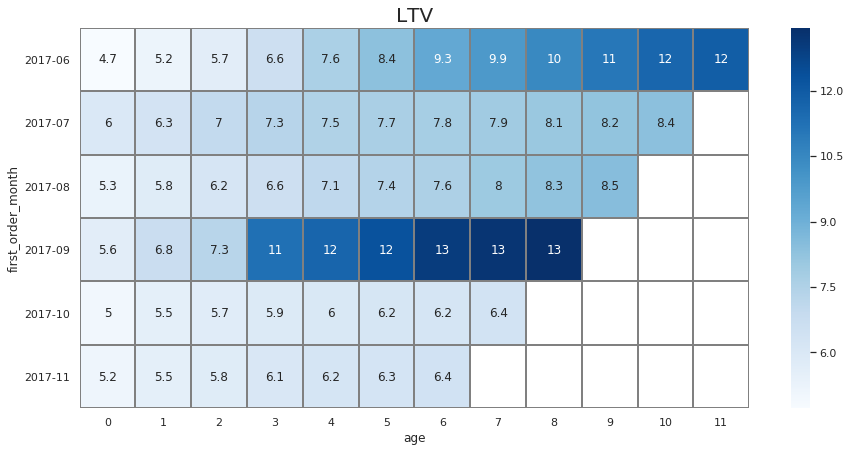

In [30]:
report['ltv'] = report['revenue'] / report['n_buyers']
ltv = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')
ltv = ltv.cumsum(axis=1).round(2)

sns.set(style='white')
plt.figure(figsize=(15, 7))
ax=sns.heatmap(ltv[:6], annot=True, linewidths=1, linecolor='gray', cmap='Blues')
plt.title('LTV', fontsize=20)
ticklabels = [ltv.index[int(tick)].strftime('%Y-%m') for tick in ax.get_yticks()] # Меняем формат тикеров на оси Y
ax.set_yticklabels(ticklabels)
plt.show()

Рассчитаем средний LTV за 6 месяцев.

In [31]:
ltv_6=ltv[:6][6].mean()
print('Средний LTV за 6 месяцев составляет {:.2f}.'.format(ltv_6))


Средний LTV за 6 месяцев составляет 8.39.


Как видим, LTV непрерывно накапливается со временем во всех когортах, а это значит, что пользователи совершают заказы и спустя несколько месяцев после регистрации, за рассмотренный период не обнаружено срока, после которого пользователи переставали бы совершать покупки. Отметим, что LTV когорты в нулевой месяц еще ни о чем не говорит, например, у июньской коорты этот показатель был самым низким по сравнению с остальными, но на третий месяц когорта уже выходит на второе место по LTV. Так же достаточно необычно выглядит динамика LTV у сентябрьской когорты - имея стандартное стартовое значение, она начинает резко расти, на первый же месяц жизни выбиваясь в лидеры, при среднем LTV за шесть месяцев 8.39 у данной когорты LTV на шестом месяце составляет  уже 13 условных едениц.

### Маркетинговые метрики
Посчитаем и отобразим на графиках, как маркетинговые метрики различаются по рекламным источникам. Один и тот же пользователь мог заходить на сайт из нескольких источников, поэтому важно определить «главный» источник для каждого и учитывать это в расчётах. Определим главный источник как источник первого перехода на ресурс.

In [32]:
# У нас уже есть день первой активности, но в первый день пользователь мог зайти с разных источников. Найдем время первой активности.
first_activity_time = visits.groupby('uid').agg({'start_ts':'min'}).reset_index() 
first_activity_time.columns = ['uid', 'first_activity_time']
visits = visits.merge(first_activity_time,on='uid')

main_source = visits.groupby(['first_activity_time', 'uid']).agg({'source_id':'mean'}).reset_index() 
# mean в данном случае просто запишет единственное значение, правда, в виде числа с плавающей точкой.
main_source.columns = ['first_activity_time', 'uid', 'main_source']
main_source['main_source'] = main_source['main_source'].astype('int')
orders = orders.merge(main_source[['main_source', 'uid']], on='uid')

#### Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам. Визуализируем изменения метрик во времени.

In [33]:
print('Всего на маркетинг потрачено',costs['costs'].sum(),'условных единиц.')

Всего на маркетинг потрачено 329131.62 условных единиц.


Для интереса посчитаем выручку.

In [34]:
print('Выручка составляет', orders['revenue'].sum().round(2),'условных единиц.')

Выручка составляет 252057.2 условных единиц.


Расходы по источникам


,costs
source_id,
1,20833.3
2,42806
3,141322
4,61073.6
5,51757.1
9,5517.49
10,5822.49


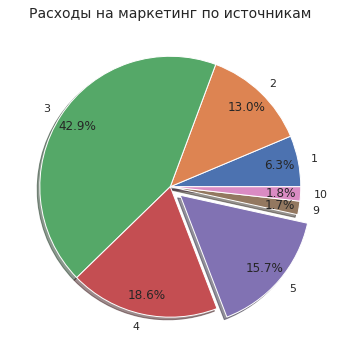

In [35]:
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

source_costs = costs.groupby('source_id').agg({'costs':'sum'})

print ('\033[4m\033[1m' + 'Расходы по источникам' + '\033[0m')
display(source_costs.style.background_gradient(cmap='Blues'))
pie, ax = plt.subplots(figsize=[10,6])
print()
print()
sources = source_costs.index.tolist()
plt.pie(x=source_costs, 
        autopct='%.1f%%', # Формат подписи
        explode = (0,0,0,0,0.1,0,0), # Вынимаем кусок пирога
        labels=sources,
        pctdistance=0.85, # Расстояние от центра до подписей
        shadow=True, 
       )
plt.title('Расходы на маркетинг по источникам', fontsize=14);
plt.show()

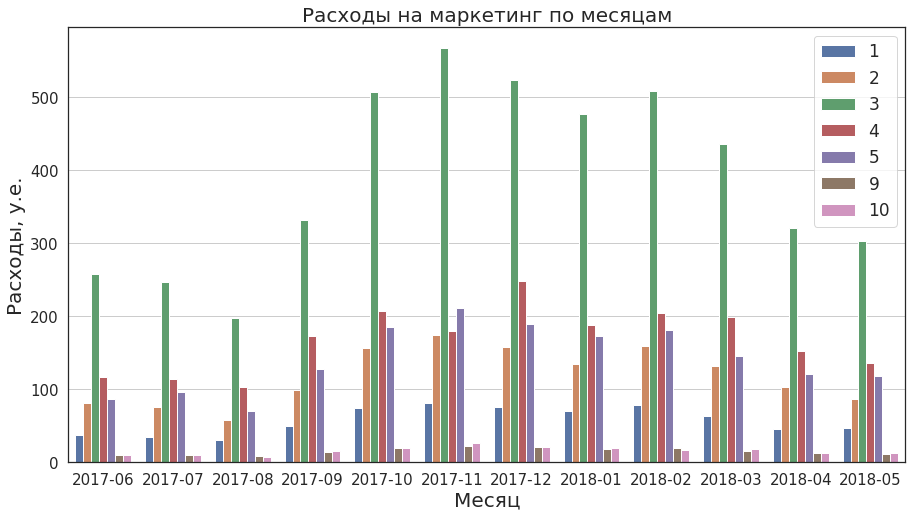

In [36]:
costs['cost_month'] = costs['dt'].astype('datetime64[M]')

plt.figure(figsize=[15,8])
ax=sns.barplot(data=costs, x=costs['cost_month'].dt.strftime('%Y-%m'), y='costs', hue='source_id', ci=None)
ax.axes.set_title('Расходы на маркетинг по месяцам',fontsize=20)
ax.set_xlabel('Месяц',fontsize=20)
ax.set_ylabel('Расходы, у.е.',fontsize=20)
ax.tick_params(labelsize=15)
ax.yaxis.grid(True)
plt.legend(loc='upper right', prop={'size': 17})
plt.show()

Как видим, больше всего средств, более 40%, было потрачено на источник трафика 3, далее идут источники 4 и 5 с 18.6% и 15.7% соответственно. Кстати, вложения в маркетинг по месяцам пропорциональны количеству новых пользователей.

#### Рассчитаем средний CAC на одного покупателя для всего проекта и для каждого источника трафика. Отразим изменения метрик на графиках.
Найдем расходы за каждый месяц, добавим данные в таблицу по LTV, где у нас уже есть данные о новых пользователях за каждый месяц. Разделим расходы на пользователей, чтобы вычислить САС. Выведем среднее значение и построим график изменения.

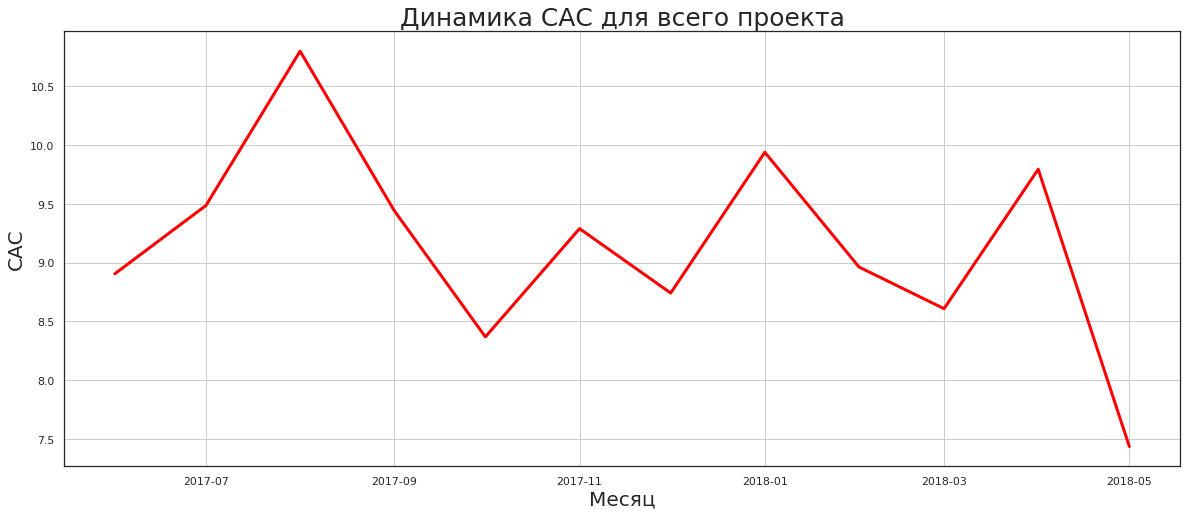

Средний САС на одного покупателя для всего проекта составляет 9.32


In [37]:
    # Расчитаем затраты в каждем месяце
costs_per_month = costs.groupby('cost_month').agg({'costs':'sum'}).reset_index()
costs_per_month.columns = ['cost_month', 'costs_per_month'] 
    # У нас уже посчитаны новые пользователи по месяцам. Присоединим таблицу с этими значениями и посчитаем САС
report_new = report.merge(costs_per_month, left_on='first_order_month', right_on='cost_month')
report_new['cac'] = report_new['costs_per_month'] / report_new['n_buyers']
    # Построим график
plt.figure(figsize=(20, 8))    
ax=sns.lineplot(data=report_new, x='first_order_month', y='cac', color='red', linewidth = 3)
ax.axes.set_title('Динамика САС для всего проекта',fontsize=25)
ax.set_xlabel('Месяц',fontsize=20)
ax.set_ylabel('САС',fontsize=20)
ax.yaxis.grid(True)
ax.xaxis.grid(True)
plt.show()

print('Средний САС на одного покупателя для всего проекта составляет {:.2f}'.format(report_new['cac'].mean()))

Средний САС превышает средний LTV для шестимесячной когорты, посмотрим, можно ли что-то изменить в лучшую сторону.

Рассчитаем средний САС на одного покупателя для каждого источника трафика. Для этого напишем функцию, которая будет считать САС помесячно для каждого источника и строить график.

Средний САС по источнику 1 составляет 8.23
Средний САС по источнику 2 составляет 7.78
Средний САС по источнику 3 составляет 13.36
Средний САС по источнику 4 составляет 6.94
Средний САС по источнику 5 составляет 9.66
Средний САС по источнику 9 составляет 11.65
Средний САС по источнику 10 составляет 7.38


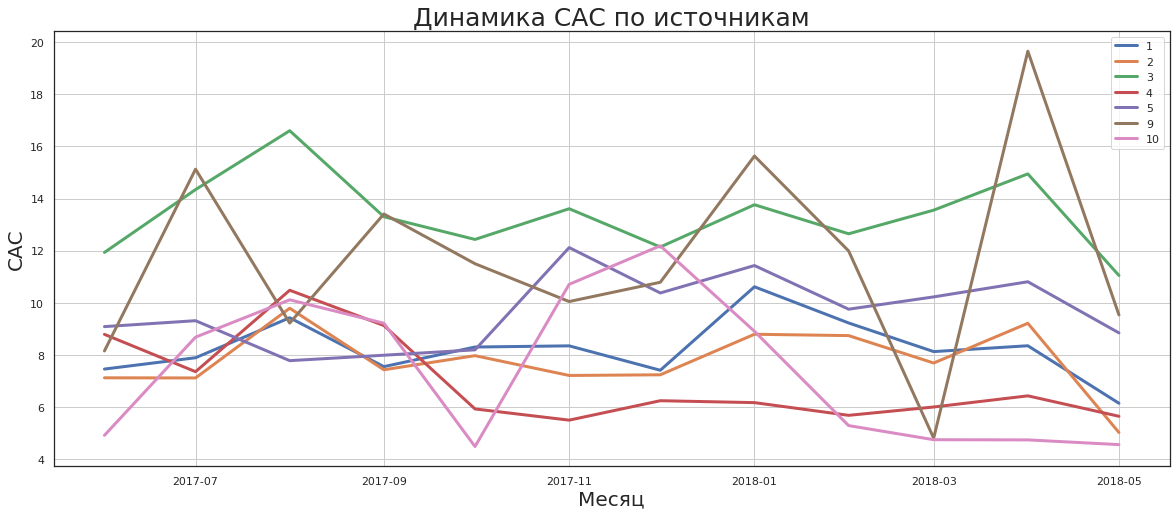

In [38]:
def cac_by_source(source):
        # Создаем таблицу с нужным источником, выберем только нужные столбцы чтобы не путаться
    orders_source = orders.loc[orders['main_source'] == source][['uid','buy_month']] 
    costs_source = costs.loc[costs['source_id'] == source][['costs', 'cost_month']] 
        # Считаем расходы по месяцам
    costs_per_month_source = costs_source.groupby('cost_month').agg({'costs':'sum'}).reset_index() 
    costs_per_month_source.columns = ['costs_month', 'costs_per_month']
        # Месяц первой покупки
    first_order_source = orders_source.groupby('uid').agg({'buy_month':'min'}).reset_index() 
    first_order_source.columns = ['uid','first_order_month']
        # Новые покупатели в каждом месяце
    cohort_sizes_source = first_order_source.groupby('first_order_month').agg({'uid':'nunique'}).reset_index() 
    cohort_sizes_source.columns = ['first_order_month','n_buyers']
        # Объединяем таблицы и считаем САС
    cac_source = cohort_sizes_source.merge(costs_per_month_source, left_on='first_order_month', right_on='costs_month')
    cac_source['cac'] = cac_source['costs_per_month'] / cac_source['n_buyers'] 
    print ('Средний САС по источнику {} составляет {:.2f}'.format(source, cac_source['cac'].mean()))
        # Строим график
    ax=sns.lineplot(data=cac_source, x='first_order_month', y='cac', linewidth = 3) 
    plt.legend(sources)
    ax.axes.set_title('Динамика САС по источникам',fontsize=25)
    ax.set_xlabel('Месяц',fontsize=20)
    ax.set_ylabel('САС',fontsize=20)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
            
plt.figure(figsize=(20, 8))    
for source in sources:
    cac_by_source(source)
    
    

Как видим, источник 3, на который было потрачено более 40% рекламного бюджета, оказался самым неэффективным с точки зрения стоимости привлечения. А вот источник 4, который находится на втором месте по затраченным средствам, напротив, отлично себя показал, у него самая низкая стоимость привлечения клиента. Но делать выводы рано, ведь для разных источников LTV клиента тоже может отличаться. Поэтому, чтобы оценить эффективность каждого источника трафика, для каждого из них рассчитаем отношение валовой прибыли к расходам на привлечение клиента, то есть **ROMI**.

#### Рассчитаем ROMI по когортам в разрезе источников. Сравним окупаемость за одинаковые периоды жизни когорт. Построим графики, отражающие изменения метрик во времени.
Напишем функцию для расчета ROMI и построения графиков по каждому источнику, применим ее в цикле.

ROMI источника 1 по месяцам жизни кагорты


,0
age,
0,0.92
1,1.22
2,1.39
3,1.5
4,1.66
5,1.91
6,2.32
7,2.68
8,3.06




ROMI источника 2 по месяцам жизни кагорты


,0
age,
0,0.85
1,0.91
2,1.1
3,1.67
4,1.95
5,2.27
6,2.23
7,2.49
8,2.91




ROMI источника 3 по месяцам жизни кагорты


,0
age,
0,0.34
1,0.36
2,0.38
3,0.41
4,0.44
5,0.46
6,0.49
7,0.52
8,0.55




ROMI источника 4 по месяцам жизни кагорты


,0
age,
0,0.67
1,0.68
2,0.69
3,0.69
4,0.69
5,0.71
6,0.71
7,0.67
8,0.66




ROMI источника 5 по месяцам жизни кагорты


,0
age,
0,0.48
1,0.49
2,0.5
3,0.51
4,0.52
5,0.56
6,0.57
7,0.62
8,0.61




ROMI источника 9 по месяцам жизни кагорты


,0
age,
0,0.32
1,0.33
2,0.36
3,0.41
4,0.37
5,0.39
6,0.33
7,0.45
8,0.39




ROMI источника 10 по месяцам жизни кагорты


,0
age,
0,0.41
1,0.32
2,0.35
3,0.27
4,0.19
5,0.38
6,0.47


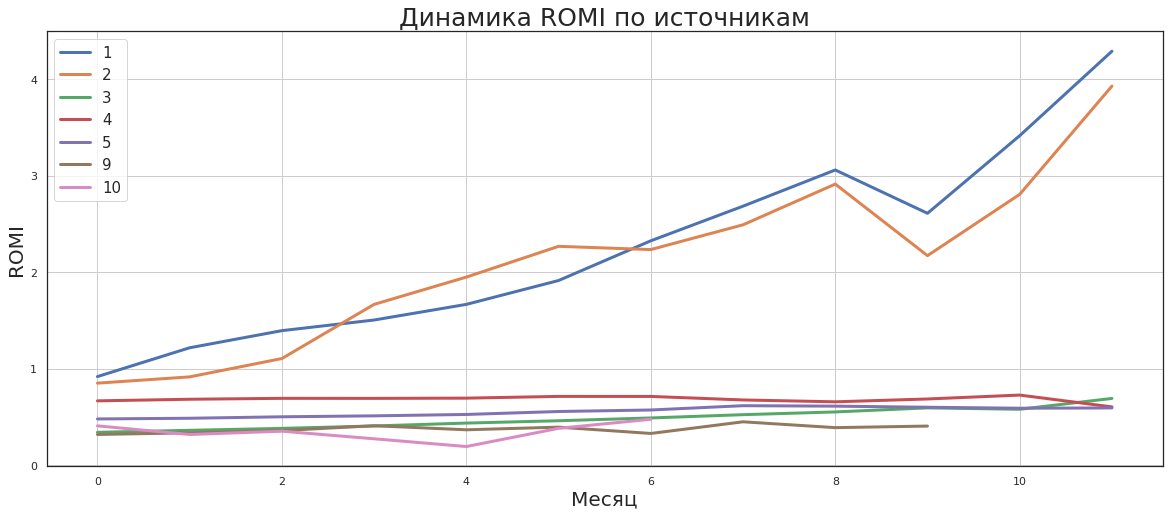

In [39]:
def romi(source):
    orders_romi = orders.loc[orders['main_source'] == source][['uid','buy_month', 'revenue']] # Таблицы с нужным источником
    costs_romi = costs.loc[costs['source_id'] == source][['costs', 'cost_month']] # Только нужные столбцы, во избежании путаницы
        # Считаем расходы по месяцам
    costs_per_month_romi = costs_romi.groupby('cost_month').agg({'costs':'sum'}).reset_index() 
    costs_per_month_romi.columns = ['costs_month', 'costs_per_month']
        # Месяц первой покупки
    first_order_romi = orders_romi.groupby('uid').agg({'buy_month':'min'}).reset_index() # Месяц первой покупки
    first_order_romi.columns = ['uid','first_order_month']
        # Новые покупатели
    cohort_sizes_romi = first_order_romi.groupby('first_order_month').agg({'uid':'nunique'}).reset_index() 
    cohort_sizes_romi.columns = ['first_order_month','n_buyers']  
        # Суммы чеков помесячно
    orders_romi = orders_romi.merge(first_order_romi, on='uid')
    cohorts_romi = orders_romi.groupby(['first_order_month', 'buy_month']).agg({'revenue': 'sum'}).reset_index() 
        # Таблица с числом покупателей, суммой чеков и затратами, все помесячно
    report_romi = cohorts_romi.merge(cohort_sizes_romi, on='first_order_month')
    report_romi = report_romi.merge(costs_per_month_romi, left_on='first_order_month', right_on='costs_month')
        # Возраст когорты
    report_romi['age'] = (report_romi['buy_month'] - report_romi['first_order_month']) / np.timedelta64(1, 'M')
    report_romi['age'] = report_romi['age'].round().astype('int')
        # LTV, САС, ROMI
    report_romi['ltv'] = report_romi['revenue'] / report_romi['n_buyers']
    report_romi['cac'] = report_romi['costs_per_month'] / report_romi['n_buyers']
    report_romi['romi'] = report_romi['ltv'] / report_romi['cac']
        # LTV, САС, ROMI по когортам
    ltv_romi = report_romi.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')
    cac_romi = report_romi.pivot_table(index='first_order_month', columns='age', values='cac', aggfunc='mean')
    romi = report_romi.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')
        # В числителе ROMI - LTV, а в числителе LTV - сумма чеков когорты, которая должна накапливаться с каждым месяцем:
        # используем кумулятивную сумму для каждой когорты. Сложим таблицу в строку, усреднив значения.
    romi = romi.cumsum(axis=1).mean(axis=0)
        # Построим графики
    ax=sns.lineplot(data=romi, linewidth = 3) # Строим график
    plt.legend(sources, prop={'size': 15})
    ax.axes.set_title('Динамика ROMI по источникам',fontsize=25)
    ax.set_xlabel('Месяц',fontsize=20)
    ax.set_ylabel('ROMI',fontsize=20)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
        # Выясним, как быстро окупится когорта. Сложим таблицу в строку, усреднив значения
    print('ROMI источника', source, 'по месяцам жизни кагорты')
    display((romi.round(2).to_frame()).style.background_gradient(cmap='Purples'))
    print()
    print()

plt.figure(figsize=(20, 8))    
for source in sources:
    romi(source)

Мы видим, что окупают вложеные средства только источники 1 и 2, а ведь на них приходится меньше 20% всего рекламного бюджета. Причем окупаются вложения по этим источникам уже на первый и второй месяцы соответственно. Остальные же источники трафика, мало того, что не окупили вложения, но еще и практически не показывают динамики, а в отдельных случаях (5,9) даже присутствует небольшая отрицательная динамика.

## Выводы и рекомендации

### Источники трафика
С точки зрения **окупаемости** вложенных в маркетинговую кампанию средств, рекомендуется в первую очередь обратить внимание на источники трафика **1 и 2**, в наблюдаемый период вложения в них окупились уже на первый и второй месяц соответственно. Остальные источники трафика в наблюдаемый период не окупились. При этом, из оставшихся источников трафика самую лучшую динамику окупаемости показал истоник 3, при существующей динамике он мог бы начать окупаться примерно через два года после первого наблюдения, возможно, этот источник целесообразно использовать при определенных условиях, например, если он способен существенно расширить охват аудитории по сравнению с другими источниками. Самую **низкую стоимость** привлечения клиента показывает источник **4**, при этом, к сожалению, его окупаемость почти не растет со временем. Возможно, есть смысл изменить параметры его применения. 
Для оценки источников трафика главным образом использовались метрики **ROMI** - окупаемость вложенных средств и **САС** - стоимость привлечения клиента.

### Маркетинговые метрики, продуктовые метрики и метрики электронной коммерции
 + Проект в среднем привлек 907 новых пользователей в день, 5716 в неделю, и 23228 в месяц.
 + Больше всего новых пользователей пришло в ноябре, декабре и октябре, летом хорошо заметен спад новых пользователей. Эти данные коррелируют с распределением маркетинговых затрат по месяцам.
 + В среднем, пользователи заходили на сайт 1.08 раз за день. Это значение незначительно колебалось в течении наблюдаемого периода
 + Чаще всего продолжительность сессии составляет 60 секунд.
 + Из пользователей, которые провели на сайте меньше минуты, в дальнейшем совершили покупку 17.07%, эти пользователи немного отличаются по доле использования мобильных устройств и источнику трафика, целесообразно прверить, все ли в порядке с мобильной версией сайта.
 + Достаточно маленькая доля пользователей продолжает пользоваться сервисом последующие месяцы после регистрации. В целом доля таких пользователей колеблется от 10% до 2%. Для примера средний Retention Rate на второй месяц «жизни» когорт составляет 5.01%
 + Чаще всего, пользователи совершают покупку в течении 60 секунд после начала сессии. Это может говорить о том, что пользователи чаще всего заходят на сайт уже с решением совершить конкретную покупку.
 + Количество покупок на покупателя соствляет около 1 в месяц регистрации и растет в дальнейшем, например за шесть месяцев на каждого покупателя приходится в среднем 1.5 покупки.
 + В целом же покупателями становятся 16.01% общего числа посетителей.
 + Средний чек составляет 4.84 условные единицы. Это значение колеблется в течении года, например, в летние месяцы средний чек может снижатся до 3.5 условных единиц.
 + LTV клиента в месяц первой покупки составляет около 5.2 условных единиц и продолжает расти в последующие месяцы. Простыми словами, LTV это чистая прибыль, которую принесет клиент за все время сотрудничества. Для примера LTV на шестой месяц составляет в среднем 8.39 условных единиц.
 + За наблюдаемый период на маркетинг было потрачено 329131.62 условных единиц, при этом выручка составила 252057.2 условных единиц. Даже при условии маржинальности 100%, что на практике сложноосуществимо, в надлюдаемый период сервис работал в минус.
 + Больше всего средств, 42.9%, было потрачено на источник трафика 3, далее идут источники 4 и 5 с 18.6% и 15.7% соответственно. Ни один из этих источников не окупился.
 + Вложения в маркетинг по месяцам пропорциональны количеству новых пользователей в эти месяцы.
 + Средняя стоимость привлечения одного клиента составляет 9.32 условных единиц.
 + Источник 3, на который было потрачено более 40% рекламного бюджета, оказался самым неэффективным с точки зрения стоимости привлечения клиента.
 
 
 ### Итоги когортного анализа
 + С точки зрения Retention Rate, самой удачной была июньская когорта, Retention Rate не только был на высоком уровне по сравнению с другими когортами, но иногда и показывал рост, что не очень типично в рамках данного исследования.
 + По количеству покупок на каждого покупателя июньская когорта тоже показала себя лучше всех - на четвертый месяц она вышла в лидеры и продолжала постоянно расти, в то время как остальные когорты росли незначительно. К примеру на седьмом месяце на ее участника приходилось 1.9 заказа, у ближайшей по значению когорты - 1.5
 + По LTV в лидеры выходит сентябрьская когорта, уже на третий месяц ее показатели почти в 2 раза превышают средние значения. Июньская когорта так же выделяется на фоне остальных.
 
 